In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
import math
from WholeBrain.Utils.p_values import plotComparisonAcrossLabels2

In [2]:
from BrainTumor.subjects import Subjects
from BrainTumor.ignition_utils import *

data_dir = "../../data"

subjects = Subjects()
subjects.initialize(data_dir)

control_subset = subjects.get_control_subset()
tumor_subset = subjects.get_tumor_subset()

print("************************* Subjects Info *************************")
subjects.pretty_print()
print("*****************************************************************")

************************* Subjects Info *************************
ID              FMRI_TR (ms)    TYPE                           VOLUME (cm³)    # REGIONS WITH TUMOR
sub-CON01       2100.0          none                           0.0             0              
sub-CON02       2100.0          none                           0.0             0              
sub-CON03       2100.0          none                           0.0             0              
sub-CON04       2100.0          none                           0.0             0              
sub-CON05       2400.0          none                           0.0             0              
sub-CON06       2400.0          none                           0.0             0              
sub-CON07       2400.0          none                           0.0             0              
sub-CON08       2400.0          none                           0.0             0              
sub-CON09       2400.0          none                           0.0        

Mean SC for control subjects

In [3]:
compound_control_sc = np.dstack([sub.preop_data.sc_dk68.weights for _, sub in control_subset.items()])
mean_control_sc = np.mean(compound_control_sc, axis=2)
std_control_sc = np.std(compound_control_sc, axis=2)

Plot the minimum std and the maximum std for the compounded control sc

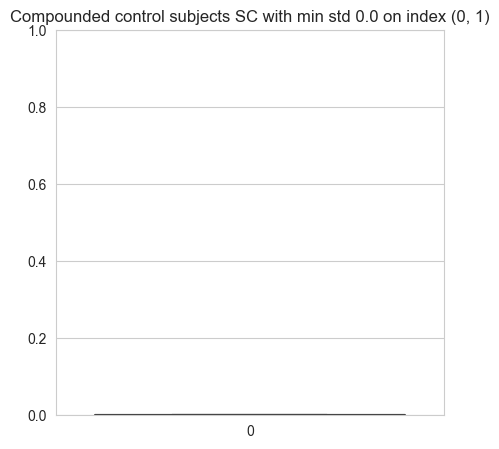

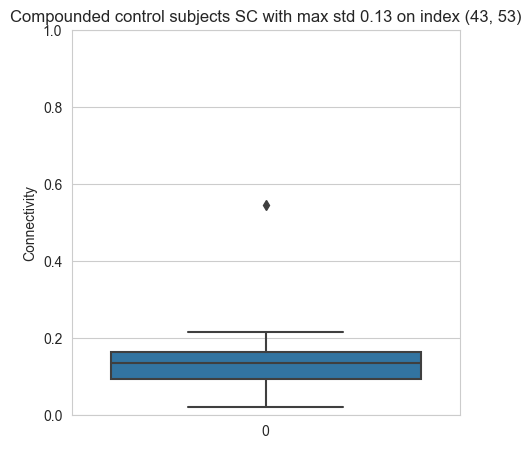

In [4]:
if True:
    aux = np.copy(std_control_sc)
    np.fill_diagonal(aux, np.Inf)
    (min_i, min_j) = np.unravel_index(np.argmin(aux), std_control_sc.shape)
    (max_i, max_j) = np.unravel_index(np.argmax(std_control_sc), std_control_sc.shape)

    plt.figure(figsize=(5, 5))
    plt.ylim(0.0, 1.0)
    sns.boxplot(data=compound_control_sc[min_i][min_j])
    plt.title(
        "Compounded control subjects SC with min std "
        + str(round(std_control_sc[min_i][min_j], 2))
        + " on index ("+str(min_i)+", "+str(min_j)+")")
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.ylim(0.0, 1.0)
    g2 = sns.boxplot(data=compound_control_sc[max_i][max_j])
    plt.ylabel("Connectivity")
    plt.title(
        "Compounded control subjects SC with max std "
        + str(round(std_control_sc[max_i][max_j], 2))
        + " on index ("+str(max_i)+", "+str(max_j)+")")
    plt.show()

Display mean control sc heatmap


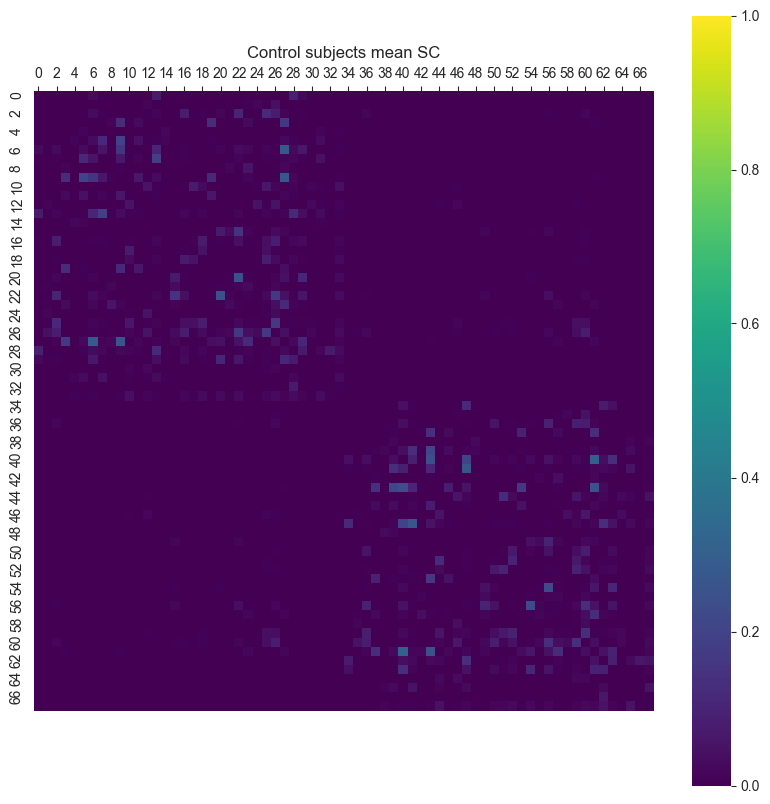

In [5]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(mean_control_sc, cmap="viridis", square=True, vmin=0.0, vmax=1.0)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.title("Control subjects mean SC")
plt.show()

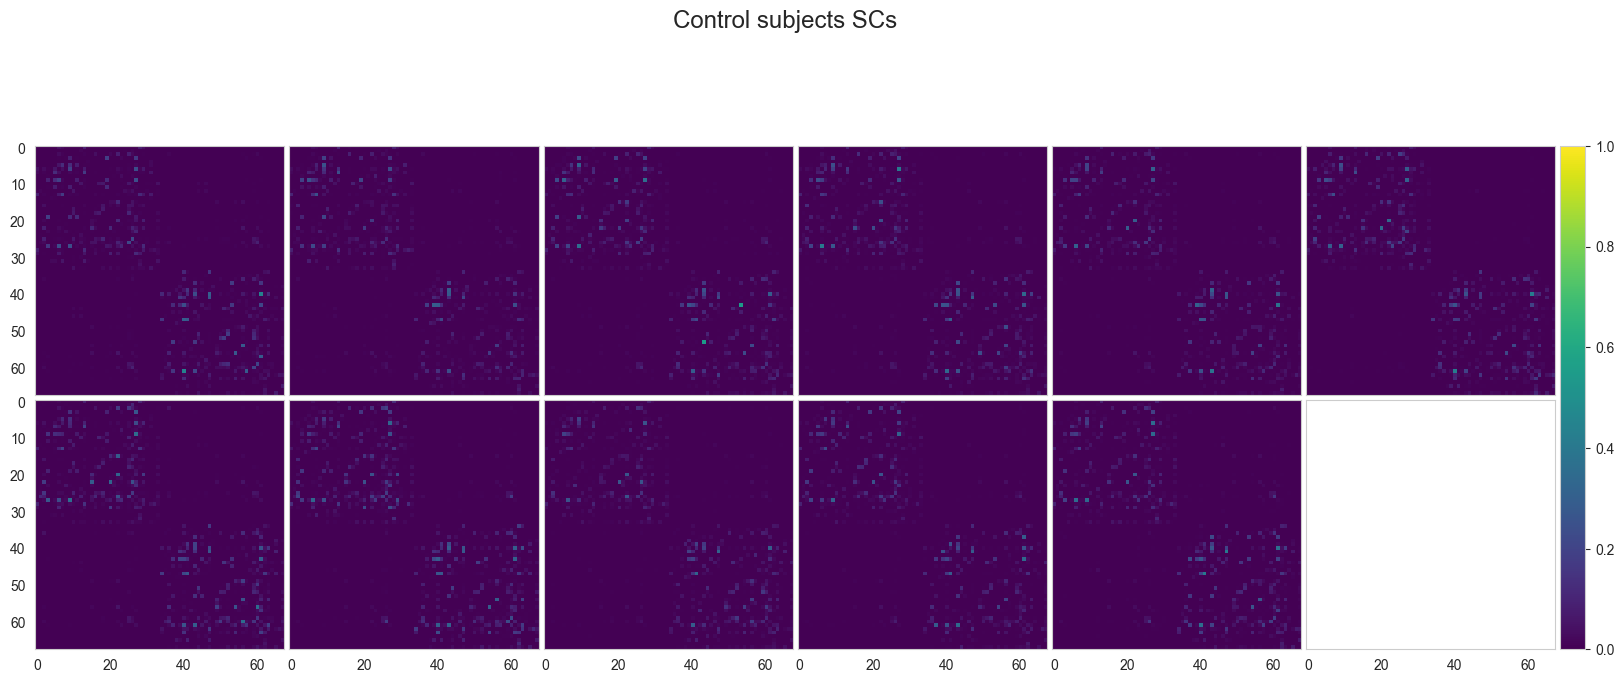

In [6]:
if True:
    scs = [sub.preop_data.sc_dk68.weights for k, sub in control_subset.items()]
    fig = plt.figure(figsize=(20, 8))

    grid = AxesGrid(
        fig,
        111,
        nrows_ncols=(2, math.ceil(control_subset.count()/2)),
        axes_pad=0.05,
        share_all=True,
        label_mode="L",
        cbar_location="right",
        cbar_mode="single"
    )

    for val, ax in zip(scs, grid):
        im = ax.imshow(val, vmin=0.0, vmax=1.0, cmap="viridis")

    grid.cbar_axes[0].colorbar(im)

    for cax in grid.axes_all:
        cax.grid(False)

    fig.suptitle("Control subjects SCs", fontsize='xx-large')
    plt.show()


Similar as in ignition, we will watch what happens on delta SC connections compared to the control subjects mean SC between three bins, tumor<->tumor, tumor<->non-tumor and non-tumor<->non-tumor.

In [7]:
t_t_bin = []
t_n_bin = []
n_n_bin = []

for k, sub in tumor_subset.items():
    # For each region connection (excluding self and repeated)
    for i in range(68):
        for j in range(i):
            delta = sub.preop_data.sc_dk68.weights[i][j] - mean_control_sc[i][j]
            # Three bins
            if sub.tumor_regions.is_tumor_region_by_id(i) and sub.tumor_regions.is_tumor_region_by_id(j):
                t_t_bin.append((k, i, j, delta))
            elif (not sub.tumor_regions.is_tumor_region_by_id(i) and sub.tumor_regions.is_tumor_region_by_id(j)) or \
                (sub.tumor_regions.is_tumor_region_by_id(i) and not sub.tumor_regions.is_tumor_region_by_id(j)):
                t_n_bin.append((k, i, j, delta))
            elif not sub.tumor_regions.is_tumor_region_by_id(i) and not sub.tumor_regions.is_tumor_region_by_id(j):
                n_n_bin.append((k, i, j, delta))

Let's visualize the three bins and compare them.

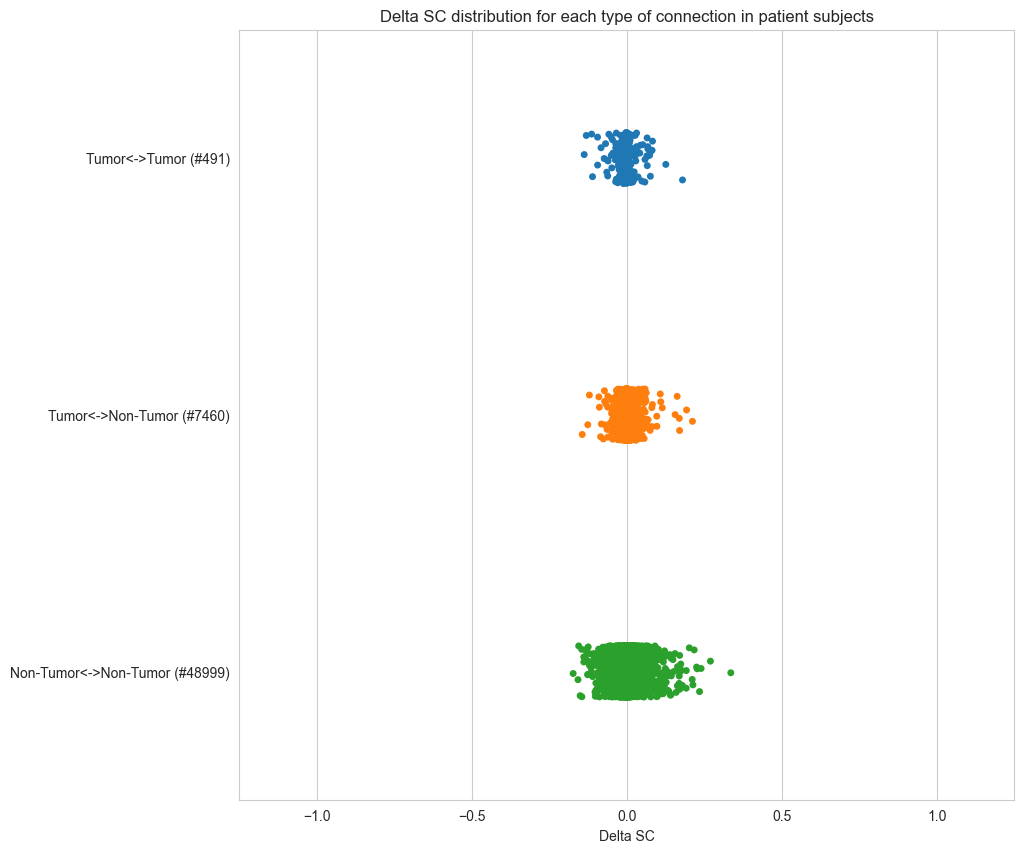

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor<->Tumor 
(#491) vs. Tumor<->Non-Tumor 
(#7460): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.106e-17 U_stat=1.418e+06
Tumor<->Non-Tumor 
(#7460) vs. Non-Tumor<->Non-Tumor 
(#48999): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.935e-32 U_stat=1.674e+08
Tumor<->Tumor 
(#491) vs. Non-Tumor<->Non-Tumor 
(#48999): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.625e-24 U_stat=8.845e+06


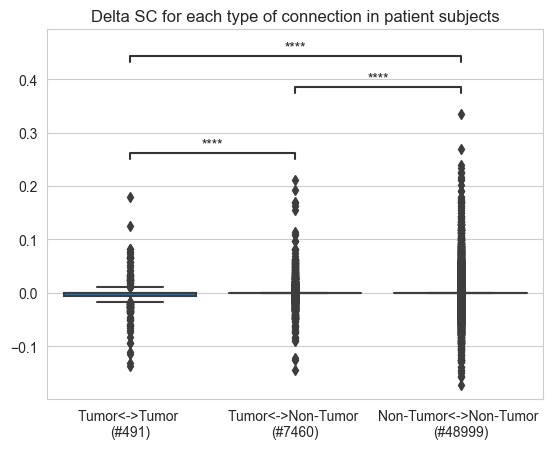

In [8]:
if True:
    t_t = [b[3] for b in t_t_bin]
    t_n = [b[3] for b in t_n_bin]
    n_n = [b[3] for b in n_n_bin]

    plt.figure(figsize=(10, 10))
    g = sns.stripplot(
        data={
            'Tumor<->Tumor (#'+str(len(t_t))+')': t_t,
            'Tumor<->Non-Tumor (#'+str(len(t_n))+')': t_n,
            'Non-Tumor<->Non-Tumor (#'+str(len(n_n))+')': n_n
        },
        orient='h',

    )
    g.set_xlim([-1.25, 1.25])
    plt.xlabel("Delta SC")
    plt.title("Delta SC distribution for each type of connection in patient subjects")
    plt.show()

    plotComparisonAcrossLabels2(
        {
            'Tumor<->Tumor \n(#'+str(len(t_t))+')': t_t,
            'Tumor<->Non-Tumor \n(#'+str(len(t_n))+')': t_n,
            'Non-Tumor<->Non-Tumor \n(#'+str(len(n_n))+')': n_n
        },
        graphLabel="Delta SC for each type of connection in patient subjects"
    )